# Package Setup

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import random
from tensorflow.keras.utils import Sequence

# GPU Setup

In [51]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Assign GPUs for multi-GPU training
        strategy = tf.distribute.MirroredStrategy()
        print(f"Number of GPUs: {strategy.num_replicas_in_sync}")
    except RuntimeError as e:
        print(e)

Number of GPUs: 2


In [52]:
# Constants
IMG_SIZE = 256
FRAME_COUNT = 10
BATCH_SIZE = 20

# Video Data Generators

In [70]:
class VideoDataGenerator(Sequence):
    def __init__(self, folders, batch_size, input_size, is_train=True):
        self.folders = folders
        self.batch_size = batch_size
        self.input_size = input_size
        self.is_train = is_train
        self.file_paths, self.labels = self._gather_files_and_labels()
    
    def _gather_files_and_labels(self):
        file_paths = []
        labels = []
        for folder in self.folders:
            folder_path = os.path.join(base_dir, folder)
            for root, _, files in os.walk(folder_path):
                for file in files:
                    if file.endswith('.mp4'):
                        file_paths.append(os.path.join(root, file))
                        if 'synthesis' in folder:
                            labels.append(1)
                        else:
                            labels.append(0)
        print(f"Gathered {len(file_paths)} file paths and {len(labels)} labels")
        return file_paths, labels

    def get_file_paths_and_labels(self):
        return self.file_paths, self.labels

# Initialize and use the data generator
data_generator = VideoDataGenerator(
    folders=['Celeb-real', 'YouTube-real', 'Celeb-synthesis'],
    batch_size=32,
    input_size=(224, 224)
)

file_paths, labels = data_generator.get_file_paths_and_labels()

print(f"File paths count: {len(file_paths)}")
print(f"Labels count: {len(labels)}")

Gathered 6529 file paths and 6529 labels
File paths count: 6529
Labels count: 6529


In [76]:
class VideoDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, input_size, is_train=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.input_size = input_size
        self.is_train = is_train
        self.indexes = np.arange(len(self.file_paths))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.file_paths) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.file_paths[k] for k in indexes]
        batch_labels = [self.labels[k] for k in indexes]
        X, y = self._generate_data(batch_paths, batch_labels)
        return X, y

    def _generate_data(self, batch_paths, batch_labels):
        X = np.zeros((len(batch_paths), FRAME_COUNT, self.input_size[0], self.input_size[1], 3))
        y = np.zeros((len(batch_paths)))
        for i, (path, label) in enumerate(zip(batch_paths, batch_labels)):
            video = self._load_video(path)
            X[i] = video
            y[i] = label
        return X, y

    def _load_video(self, path):
        # Load and preprocess video frames here
        # Example: Extract frames, resize to input_size, etc.
        video = []
        cap = cv2.VideoCapture(path)
        for _ in range(FRAME_COUNT):
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, self.input_size)
            video.append(frame)
        cap.release()
        return np.array(video)
    
    def on_epoch_end(self):
        if self.is_train:
            np.random.shuffle(self.indexes)

In [77]:
# Initialize data generators
train_generator = VideoDataGenerator(
    file_paths=train_paths,
    labels=train_labels,
    batch_size=32,
    input_size=(224, 224),
    is_train=True
)

val_generator = VideoDataGenerator(
    file_paths=val_paths,
    labels=val_labels,
    batch_size=32,
    input_size=(224, 224),
    is_train=False
)

test_generator = VideoDataGenerator(
    file_paths=test_paths,
    labels=test_labels,
    batch_size=32,
    input_size=(224, 224),
    is_train=False
)

# Loading Dataset

In [71]:
base_dir = '/kaggle/input/celeb-df-v2'

In [72]:
folders = ['Celeb-real', 'YouTube-real', 'Celeb-synthesis']

# Train-Test Split

In [75]:
# Correct data generator initialization
train_generator = VideoDataGenerator(folders=['Celeb-real', 'YouTube-real', 'Celeb-synthesis'],
                                     batch_size=32,
                                     input_size=(224, 224),
                                     is_train=True)
val_generator = VideoDataGenerator(folders=['Celeb-real', 'YouTube-real', 'Celeb-synthesis'],
                                   batch_size=32,
                                   input_size=(224, 224),
                                   is_train=False)
test_generator = VideoDataGenerator(folders=['Celeb-real', 'YouTube-real', 'Celeb-synthesis'],
                                    batch_size=32,
                                    input_size=(224, 224),
                                    is_train=False)

# Initialize the data generator and perform the data split
file_paths, labels = VideoDataGenerator(folders=['Celeb-real', 'YouTube-real', 'Celeb-synthesis'],
                                         batch_size=32,
                                         input_size=(224, 224))._gather_files_and_labels()

train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.2, stratify=train_labels)

# Print debug information
print(f"Train paths count: {len(train_paths)}")
print(f"Validation paths count: {len(val_paths)}")
print(f"Test paths count: {len(test_paths)}")

Gathered 6529 file paths and 6529 labels
Gathered 6529 file paths and 6529 labels
Gathered 6529 file paths and 6529 labels
Gathered 6529 file paths and 6529 labels
Gathered 6529 file paths and 6529 labels
Train paths count: 4178
Validation paths count: 1045
Test paths count: 1306


In [73]:
# Split files for train, validation, and test
file_paths, labels = VideoDataGenerator(folders, batch_size=32, input_size=(224, 224))._gather_files_and_labels()

# Split into train, test, and validation sets
train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.2, stratify=train_labels)


Gathered 6529 file paths and 6529 labels
Gathered 6529 file paths and 6529 labels


In [78]:
train_generator = VideoDataGenerator(train_paths, train_labels, batch_size=32, input_size=(224, 224), is_train=True)
val_generator = VideoDataGenerator(val_paths, val_labels, batch_size=32, input_size=(224, 224), is_train=False)
test_generator = VideoDataGenerator(test_paths, test_labels, batch_size=32, input_size=(224, 224), is_train=False)

# Model Building

In [83]:
# Define the shape of the input video
input_shape = (10, 224, 224, 3)

# CNN Model
with tf.distribute.MirroredStrategy().scope():  # Use strategy scope to utilize multiple GPUs
    inputs = Input(shape=input_shape)

    # Convolutional Layer 1
    x = Conv3D(32, (3, 3, 3), activation='relu', padding='same', name='conv3d_1')(inputs)
    x = BatchNormalization(name='batch_normalization_1')(x)
    x = MaxPooling3D((2, 2, 2), name='max_pooling3d_1')(x)

    # Convolutional Layer 2
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv3d_2')(x)
    x = BatchNormalization(name='batch_normalization_2')(x)
    x = MaxPooling3D((2, 2, 2), name='max_pooling3d_2')(x)

    # Convolutional Layer 3
    x = Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv3d_3')(x)
    x = BatchNormalization(name='batch_normalization_3')(x)
    x = MaxPooling3D((2, 2, 2), name='max_pooling3d_3')(x)

    # Flatten
    x = Flatten(name='flatten')(x)

    # Dense Layer
    x = Dense(128, activation='relu', name='dense_1')(x)
    x = Dropout(0.5, name='dropout')(x)

    # Output Layer
    outputs = Dense(1, activation='sigmoid', name='output')(x)

    # Create Model
    model = Model(inputs=inputs, outputs=outputs, name='DeepFakeDetectionModel')

    # Compile Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary to verify
model.summary()

Model: "DeepFakeDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 224, 224,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 224, 224,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 112, 112,    │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 112, 112,    │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 112, 112,    │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 56, 56, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 56, 56, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 56, 56, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,125,505 (50.07 MB)

 Trainable params: 13,125,057 (50.07 MB)

 Non-trainable params: 448 (1.75 KB)

# Model Training

In [84]:
# Ensure you have defined the base_dir and folders correctly
base_dir = '/kaggle/input/celeb-df-v2'
folders = ['Celeb-real', 'YouTube-real', 'Celeb-synthesis']


In [85]:
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.7880 - loss: 9.9856 - val_accuracy: 0.8203 - val_loss: 1.8708
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.8658 - loss: 0.8212 - val_accuracy: 0.8555 - val_loss: 0.5075
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8667 - loss: 0.5121 - val_accuracy: 0.8555 - val_loss: 0.4159
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8663 - loss: 0.5095 - val_accuracy: 0.8555 - val_loss: 0.4316
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.8648 - loss: 0.4640 - val_accuracy: 0.8555 - val_loss: 0.4246
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8710 - loss: 0.4569 - val_accuracy: 0.8555 - val_loss: 0.4152
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.8674 - loss: 0.4251 - val_accuracy: 0.8555 - val_loss: 0.4103
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8664 - loss: 0.4331 - val_accuracy: 0.832

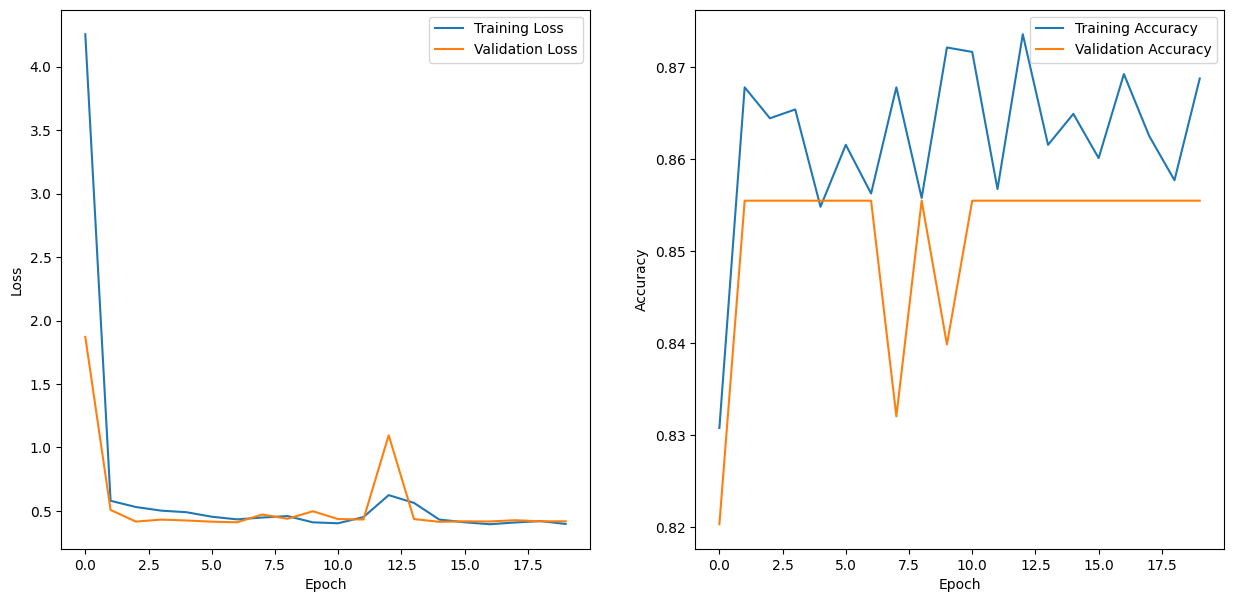

In [89]:
import matplotlib.pyplot as plt

# Example plots
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [91]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Print test accuracy and test loss
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

40/40 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8667 - loss: 0.4102
Test Loss: 0.4072
Test Accuracy: 86.41%


In [93]:
# Save the model using TensorFlow SavedModel format
model.save('deepfake_detection_model.h5')

# Loading Dataset

In [34]:
# Paths to real and fake video datasets
real_videos_dir = '/kaggle/input/celeb-df-v2/Celeb-real'
fake_videos_dir = '/kaggle/input/celeb-df-v2/Celeb-synthesis'

In [35]:
# ! kaggle datasets download reubensuju/celeb-df-v2

In [36]:
# prompt: extract zip dataset

# !unzip celeb-df-v2.zip
